In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import os
import pandas as pd

benign_dirs = [
    r"C:\Users\adity\Documents\Aditya RSET\Main Project\2.0\The IQ-OTHNCCD lung cancer dataset\Bengin cases"

]

Malignant_dir = [ r"C:\Users\adity\Documents\Aditya RSET\Main Project\2.0\The IQ-OTHNCCD lung cancer dataset\Malignant cases"]

Normal_dirs = [
    r"C:\Users\adity\Documents\Aditya RSET\Main Project\2.0\The IQ-OTHNCCD lung cancer dataset\Normal cases"
]

filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

                                           filepaths  labels
0  C:\Users\adity\Documents\Aditya RSET\Main Proj...  benign
1  C:\Users\adity\Documents\Aditya RSET\Main Proj...  benign
2  C:\Users\adity\Documents\Aditya RSET\Main Proj...  benign
3  C:\Users\adity\Documents\Aditya RSET\Main Proj...  benign
4  C:\Users\adity\Documents\Aditya RSET\Main Proj...  benign
labels
Malignant    561
Normal       416
benign       120
Name: count, dtype: int64


In [ ]:
Lung_df.shape

(1097, 2)

In [ ]:
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=40)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=40
                                )

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(613, 2)
(330, 2)
(154, 2)
(767, 2)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to address class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_set['labels']), y=train_set['labels'])
class_weight_dict = dict(enumerate(class_weights))

# Data augmentation for the benign class
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,  # Rotation
    zoom_range=0.2,     # Zoom
    horizontal_flip=True # Horizontal flip
)

# Train set with class weights and augmented data
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False,
    class_weight=class_weight_dict
)

# Test set without class weights
test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)

# Validation set without class weights
val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=8,
    shuffle=False
)


Found 613 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.
Found 154 validated image filenames belonging to 3 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Malignant', 'Normal', 'benign']


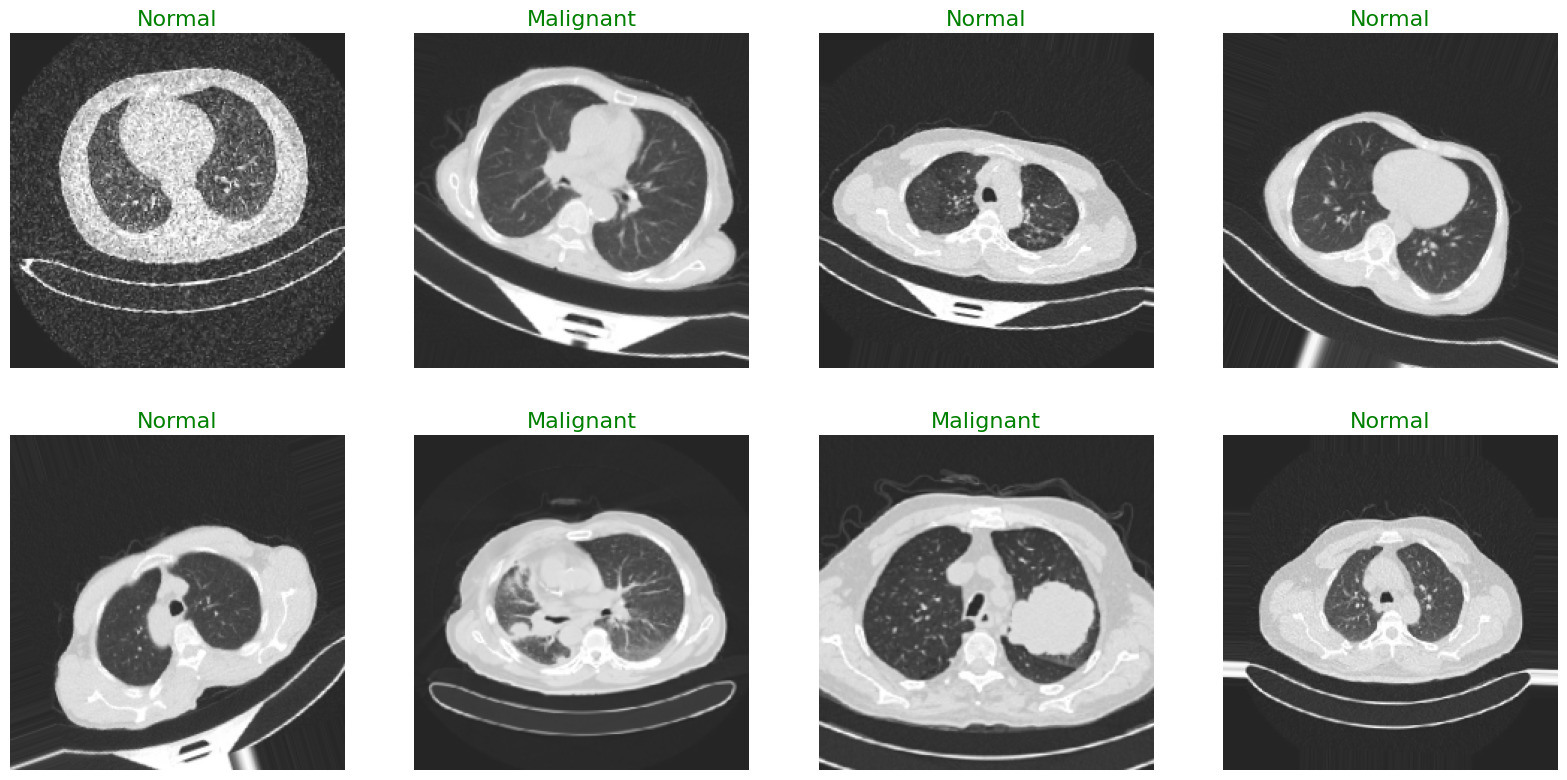

In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(4,4,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf

# Load EfficientNetB0 without the top classification layer
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top 40 layers for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Construct the model with EfficientNet as the backbone
x = base_model.output
x = BatchNormalization()(x)

# First convolutional block
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)  # First MaxPooling

# Second convolutional block
x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

# Third convolutional block
x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Fully connected layers (Dense)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Increased dropout to prevent overfitting
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer (softmax for multi-class classification)
x = Dense(3, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a higher learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Increased learning rate
    metrics=['accuracy']
)

# Model summary (optional to print)
# model.summary()
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Train the model with the increased learning rate and callbacks
history = model.fit(
    train,  # Ensure this is the correct training data (can be a DataLoader or ImageDataGenerator)
    epochs=30,  # Adjust based on how the model performs
    validation_data=val,  # Validation data (make sure it's a valid DataLoader or ImageDataGenerator)
    callbacks=[early_stopping, lr_scheduler],  # Add both early stopping and learning rate scheduler
    batch_size=32  # You can adjust the batch size based on your GPU capacity
)


Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 102s 880ms/step - accuracy: 0.5599 - loss: 0.9199 - val_accuracy: 0.4091 - val_loss: 1.1133 - learning_rate: 1.0000e-04
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 858ms/step - accuracy: 0.8323 - loss: 0.4310 - val_accuracy: 0.4091 - val_loss: 1.4754 - learning_rate: 1.0000e-04
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 855ms/step - accuracy: 0.8287 - loss: 0.3948 - val_accuracy: 0.4091 - val_loss: 1.3044 - learning_rate: 1.0000e-04
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.8340 - loss: 0.3943
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 863ms/step - accuracy: 0.8342 - loss: 0.3939 - val_accuracy: 0.4091 - val_loss: 1.2187 - learning_rate: 1.0000e-04
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 857ms/step - accuracy: 0.8738 - loss: 0.2744 - val_accuracy: 0.4740 - val_loss: 1.1626 - learning_rate: 1.0000e-05
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 66s 856ms/step - accuracy

In [ ]:
model.evaluate(test, verbose=1),
model.evaluate(train,verbose=1),
model.evaluate(val,verbose=1)

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9039 - loss: 0.2192
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.9279 - loss: 0.1800
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9009 - loss: 0.2634


[0.2628401219844818, 0.8961039185523987]

In [ ]:
model.save("Eff1.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step


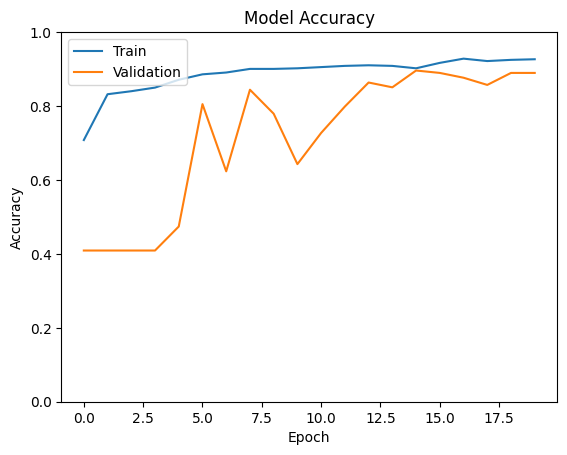

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)  # Set y-axis limit from 0.5 to 1
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


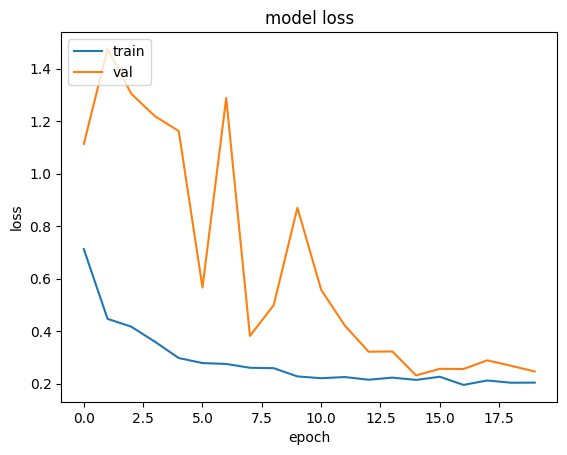

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

   Malignant       0.99      0.99      0.99       171
      Normal       0.83      0.94      0.88       121
      benign       0.73      0.42      0.53        38

    accuracy                           0.91       330
   macro avg       0.85      0.78      0.80       330
weighted avg       0.90      0.91      0.90       330

Accuracy of the Model: 90.6%


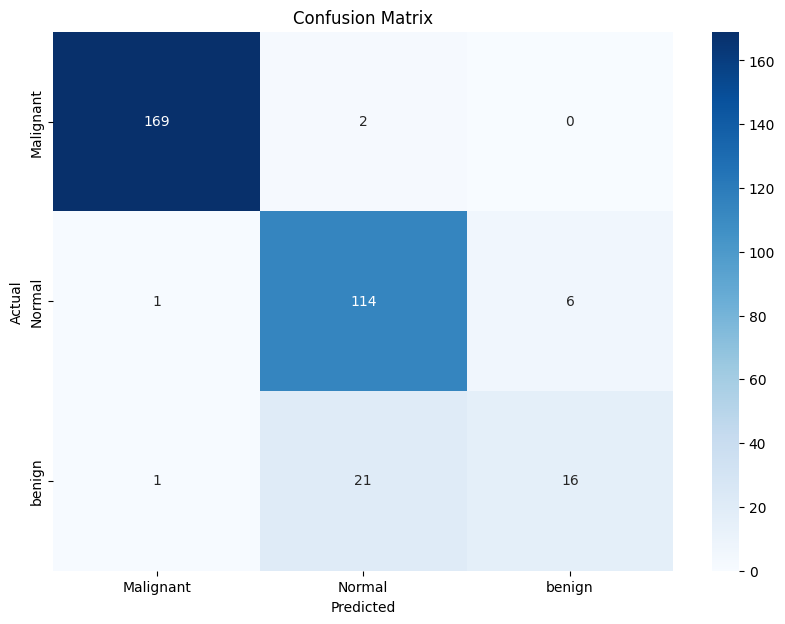

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Malignant', 'Normal', 'benign']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Function to preprocess the image
def preprocess_image(img_path, target_size=(224, 224)):  # Change the target size to (244, 244)
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)  # Resize to (244, 244)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


# Function to generate Grad-CAM++ heatmap
def get_gradcam_plus_plus(model, img_array, layer_name, class_idx):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    first = tf.exp(loss) * grads
    second = tf.exp(loss) * grads**2
    third = tf.exp(loss) * grads**3

    global_sum = tf.reduce_sum(conv_outputs, axis=(0, 1, 2))

    alpha_num = second
    alpha_denom = 2 * second + third * global_sum
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))

    alphas = alpha_num / alpha_denom
    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(0, 1))
    activation_map = tf.reduce_sum(weights * conv_outputs, axis=-1).numpy()[0]

    heatmap = np.maximum(activation_map, 0)
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]
    return heatmap

# Function to overlay heatmap on the original image
def overlay_heatmap(img_path, heatmap, intensity=0.5):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1-intensity, heatmap, intensity, 0)
    return overlay

# Load the saved model
model = tf.keras.models.load_model('Eff1.h5')

# Now you can proceed with the Grad-CAM integration


# Set the image path (replace with the actual path)
img_path = r"C:\Users\adity\Documents\Aditya RSET\Main Project\2.0\The IQ-OTHNCCD lung cancer dataset\Bengin cases\Bengin case (10).jpg"  # Replace with your image path
img_array = preprocess_image(img_path)

# Get predictions from the model
predictions = model.predict(img_array)
class_idx = np.argmax(predictions[0])  # Class index with highest probability

# Specify the layer for Grad-CAM++ (use the last convolutional layer of your model)
layer_name = 'conv5_block16_2_conv'  # Change this to the last convolutional layer of your custom model

# Generate Grad-CAM++ heatmap
heatmap = get_gradcam_plus_plus(model, img_array, layer_name, class_idx)

# Overlay heatmap on the original image
overlay_img = overlay_heatmap(img_path, heatmap)

# Display the original image and the overlay image using matplotlib
plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(1, 2, 1)
original_img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

# Show the Grad-CAM++ overlay image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM++ Overlay")
plt.show()


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 244, 244, 3), found shape=(1, 224, 224, 3)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img_path = r"C:\Users\adity\Documents\Aditya RSET\Main Project\2.0\The IQ-OTHNCCD lung cancer dataset\Bengin cases\Bengin case (32).jpg" # Update this to your image path
img = image.load_img(img_path, target_size=(244, 244))  # Resize to match model input size

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match (1, 244, 244, 3)

# Preprocess the image (same preprocessing as used during training)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Predict using the trained model
prediction = model.predict(img_array)
class_idx = np.argmax(prediction)  # Get the index of the predicted class
class_name = class_labels[class_idx]  # Convert index to class name

print(f"Predicted class: {class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Predicted class: benign


In [ ]:
import pickle
with open('class_labels.pkl', 'wb') as f:
    pickle.dump(class_labels, f)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Load the image
img_path = r"C:\Users\adity\Documents\Aditya RSET\Main Project\2.0\The IQ-OTHNCCD lung cancer dataset\Normal cases\Normal case (87).jpg"  # Update this to your image path
img = image.load_img(img_path, target_size=(244, 244))  # Resize to match model input size

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match (1, 224, 224, 3)

# Preprocess the image (same preprocessing as used during training)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Load the model
model = tf.keras.models.load_model('Eff1.h5')  # Ensure to load your saved model

# Class labels as per your training
class_labels = ['Malignant', 'Normal', 'benign']

# Predict using the trained model
prediction = model.predict(img_array)
class_idx = np.argmax(prediction)  # Get the index of the predicted class
class_name = class_labels[class_idx]  # Convert index to class name

print(f"Predicted class: {class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: benign
